#### Начнем с датасета с явно выраженными периодами:

This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('raw.githubusercontent.com_jbrownlee_Datasets_master_daily-min-temperatures.csv')
df['Date'] = pd.to_datetime(df['Date'])

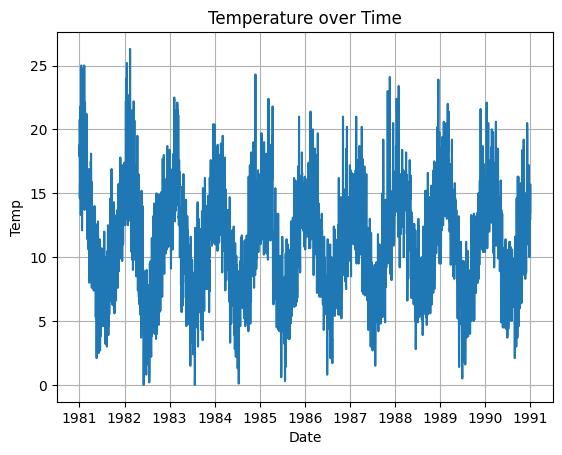

In [16]:
plt.plot(df['Date'], df['Temp'])
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Temperature over Time')
plt.grid(True)
plt.show()

In [17]:
# Leave only first 1000 rows in dataset
df = df[:1000]

In [18]:
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
995,1983-09-23,12.9
996,1983-09-24,7.7
997,1983-09-25,7.6
998,1983-09-26,3.5


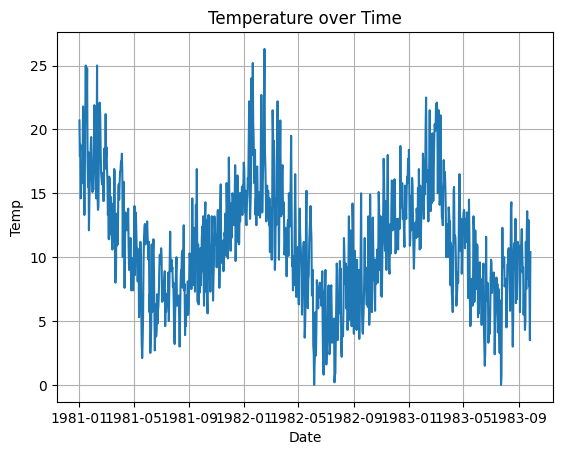

In [19]:
plt.plot(df['Date'], df['Temp'])
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Temperature over Time')
plt.grid(True)
plt.show()

#### Для начала попробуем сами найти размерности

Размерность вложения будем искать с помощью Метода "False Nearest Neighbors"
Корреляционную размерность будем искать с помощью корреляционного интеграла

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# Определите начальную размерность вложения и задержку времени
embedding_dimension = 3
time_delay = 1

# Создайте фазовое пространство для корреляционной размерности
def create_phase_space(data, embedding_dimension, time_delay):
    N = len(data)
    phase_space = np.empty((N - (embedding_dimension - 1) * time_delay, embedding_dimension))
    for i in range(embedding_dimension):
        phase_space[:, i] = data[i * time_delay : N - (embedding_dimension - 1) * time_delay + i * time_delay]
    return phase_space

# Вычисление корреляционной размерности через корреляционный интеграл
def calculate_correlation_dimension(data, embedding_dimension, time_delay):
    phase_space = create_phase_space(data, embedding_dimension, time_delay)
    distances = pairwise_distances(phase_space, metric='euclidean')
    neigh = NearestNeighbors(n_neighbors=2)
    neigh.fit(phase_space)
    k_distances = neigh.kneighbors()[0][:, 1]
    C = np.sum(distances < k_distances[:, np.newaxis]) / (len(data) * (len(data) - 1))
    return C

# Вычисление размерности вложения с помощью метода False Nearest Neighbors
def false_nearest_neighbors(data, max_dimension, time_delay, threshold):
    dimensions = list(range(1, max_dimension + 1))
    false_neighbors = []

    for d in dimensions:
        phase_space = create_phase_space(data, d, time_delay)
        neighbors = NearestNeighbors(n_neighbors=1).fit(phase_space)
        distances, _ = neighbors.kneighbors(phase_space)
        max_radius = 10 * np.std(data)
        false_count = 0

        for i in range(len(phase_space)):
            for j in range(i + 1, len(phase_space)):
                if distances[i][j] < max_radius:
                    false_count += 1

        false_neighbors.append(false_count)

    optimal_dimension = dimensions[np.where(np.array(false_neighbors) / len(data) < threshold)[0][0]]

    return optimal_dimension

# Вычислите корреляционную размерность
corr_dim = calculate_correlation_dimension(df['Temp'], embedding_dimension, time_delay)
print(f"Correlation Dimension: {corr_dim}")

# Вычислите размерность вложения с помощью метода False Nearest Neighbors
max_embedding_dimension = 10  # Максимальная проверяемая размерность
threshold = 0.01  # Порог для определения ложных соседей
optimal_dimension = false_nearest_neighbors(df['Temp'], max_embedding_dimension, time_delay, threshold)
print(f"Optimal Embedding Dimension: {optimal_dimension}")


Correlation Dimension: 0.0024584584584584584


IndexError: index 1 is out of bounds for axis 0 with size 1

#### Попробуем использовать библиотеку Giotto

Полезная ссылка: https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html


In [27]:
#!python3 -m pip install -U giotto-tda

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [28]:
from gtda.time_series import embedding, TakensEmbedding
optimal_time_delay, optimal_embedding_dimension = embedding.takens_embedding_optimal_parameters(
    df['Temp'], 100, 10, stride=1
    )
print(f"Optimal embedding dimension is {optimal_embedding_dimension} and time delay is {optimal_time_delay}")

ModuleNotFoundError: No module named 'gtda'

#### Изобразим фазовую траекторию

In [ ]:
from sklearn.manifold import TSNE

phase_space = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df['Temp'].values.reshape(1, -1))[0]

# Создайте экземпляр t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

# Преобразуйте фазовую траекторию в двумерное пространство
tsne_results = tsne.fit_transform(phase_space)

In [ ]:
import matplotlib.pyplot as plt

# Создайте график фазовой траектории
plt.plot(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization of Phase Space Trajectory')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

#### Попробуем трехмерный график

In [ ]:
phase_traj = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df['Temp'].values.reshape(1, -1))[0]
tsne = TSNE(n_components=3)
phase_traj_proj = tsne.fit_transform(phase_traj)

In [ ]:
import plotly.express

fig = plotly.express.line_3d(pd.DataFrame(phase_traj_proj, columns=['x', 'y', 'z']), x="x", y="y", z="z")

fig.show()

#### Теперь временной ряд без периодов

еще полезная ссылка
https://towardsdatascience.com/time-series-forecasting-with-dynamical-systems-methods-fa4afdf16fd0

In [ ]:
df2 = pd.read_csv('BBG00B3T3HD3.csv')[:1000]
df2

In [ ]:
from gtda.time_series import embedding, TakensEmbedding
optimal_time_delay, optimal_embedding_dimension = embedding.takens_embedding_optimal_parameters(
    df2['close'], 100, 10, stride=1
    )
print(f"Optimal embedding dimension is {optimal_embedding_dimension} and time delay is {optimal_time_delay}")

In [ ]:
from sklearn.manifold import TSNE

phase_space = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df2['close'].values.reshape(1, -1))[0]

# Создайте экземпляр t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

# Преобразуйте фазовую траекторию в двумерное пространство
tsne_results = tsne.fit_transform(phase_space)

In [ ]:
import matplotlib.pyplot as plt

# Создайте график фазовой траектории
plt.plot(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization of Phase Space Trajectory')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
phase_traj = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df2['close'].values.reshape(1, -1))[0]
tsne = TSNE(n_components=3)
phase_traj_proj = tsne.fit_transform(phase_traj)

In [ ]:
import plotly.express

fig = plotly.express.line_3d(pd.DataFrame(phase_traj_proj, columns=['x', 'y', 'z']), x="x", y="y", z="z")

fig.show()

#### ЛР2

In [23]:
from gtda.time_series import embedding, TakensEmbedding
optimal_time_delay, optimal_embedding_dimension = embedding.takens_embedding_optimal_parameters(
    df['Temp'], 100, 10, stride=1
    )
print(f"Optimal embedding dimension is {optimal_embedding_dimension} and time delay is {optimal_time_delay}")

phase_space = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df['Temp'].values.reshape(1, -1))[0]

ModuleNotFoundError: No module named 'gtda'

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(phase_space)
# Создайте график фазовой траектории
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization of Phase Space Trajectory')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Побьем на кластеры первый датасет с помощью AgglomerativeClustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=4, linkage='ward', metric='euclidean')

clustering.fit(phase_space)

In [ ]:
cluster_df = pd.concat([pd.DataFrame(phase_space, columns=[i for i in range(5)]), pd.DataFrame(clustering.labels_.reshape(-1, 1), columns=['cluster'])], axis=1)

In [ ]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_df['cluster'])
plt.title('t-SNE Visualization of Phase Space Trajectory')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
cluster_df

Найдем вероятности состояний